<a href="https://colab.research.google.com/github/naranjoc/LSTM-Inflation-Rate/blob/main/LSTM_Inflation_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inflation Rate Forecasting**
Esteban Nicolas Naranjo Castiblanco - enaranjoc@unal.edu.co

## **Base Project**
This project is based on the following article

> *Colombian inflation forecast using Long Short-Term Memory approach* URL: https://repositorio.banrep.gov.co/server/api/core/bitstreams/4b785d6c-4bdd-4e09-b289-96d47a44a57c/content



## **Introduction**

This project is based on research conducted by Cárdenas et al. (2023), which uses Long Short-Term Memory (LSTM) neural networks to forecast inflation in Colombia with a twelve-month horizon. Its importance is significant due to its impact on resource allocation, purchasing power, and investment decisions.

For institutions such as the Banco de la República (BR), which is responsible for monetary policy, having accurate inflation projections is crucial. When inflation remains low and stable, it allows for sustainable levels of production and employment. Consequently, the bank aims to improve its forecasts by using artificial intelligence techniques, such as LSTM neural networks, to diversify its methods and enhance the precision of inflation projections.

Recognizing patterns in sequential data presents an opportunity to apply machine learning and deep learning to time series forecasting. Methods like Recurrent Neural Networks (RNN), which process time series step by step using lags, and LSTM networks, which incorporate long-term dependencies, offer better performance in predictions compared to traditional methodologies. However, this comes with the drawback that the model's accuracy contrasts with its limited ability to identify the forces that define its projections, complicating interpretability. Therefore, this research focuses exclusively on predictive capabilities.

## **Packages**

In [ ]:
!pip install bayesian-optimization
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", module="keras")

## **Dataset**

The data focuses on headline inflation in Colombia, measured by the annual variation of the Consumer Price Index (CPI), calculated monthly by the National Administrative Department of Statistics (DANE). The dataset spans from January 2004 to December 2023 starting after Colombia adopted the inflation targeting strategy and a flexible exchange rate system, which are still in place. To avoid the unusual inflation behavior caused by the COVID-19 pandemic, the LSTM model's sample ends before the pandemic began. Autors assumption is that inflation will return to more traditional patterns after the shocks caused by the pandemic and other recent events, such as the Russia-Ukraine conflict, are resolved.

In [ ]:
data = pd.read_excel('/content/Inflation_data.xlsx')
data=data.dropna(subset=['Inflation'])
data['FECHA'] = pd.to_datetime(data['FECHA'])
data.set_index('FECHA', inplace=True)
data.head()

,ANIO,MES,IPC,Inflation,TRM_promedio,TRM_cierre,ISE,PRECIP_GAP
FECHA,,,,,,,,
2004-01-01,2004,1,53.54,0.061880,2749.14,2742.47,NaN,-224.332411
2004-02-01,2004,2,54.18,0.062770,2717.94,2682.34,NaN,-251.224087
2004-03-01,2004,3,54.71,0.062124,2670.80,2678.16,NaN,-387.392292
2004-04-01,2004,4,54.96,0.054894,2639.60,2646.99,NaN,230.907115
2004-05-01,2004,5,55.17,0.053667,2719.43,2724.92,NaN,207.587352


This is how inflation series look over the time.

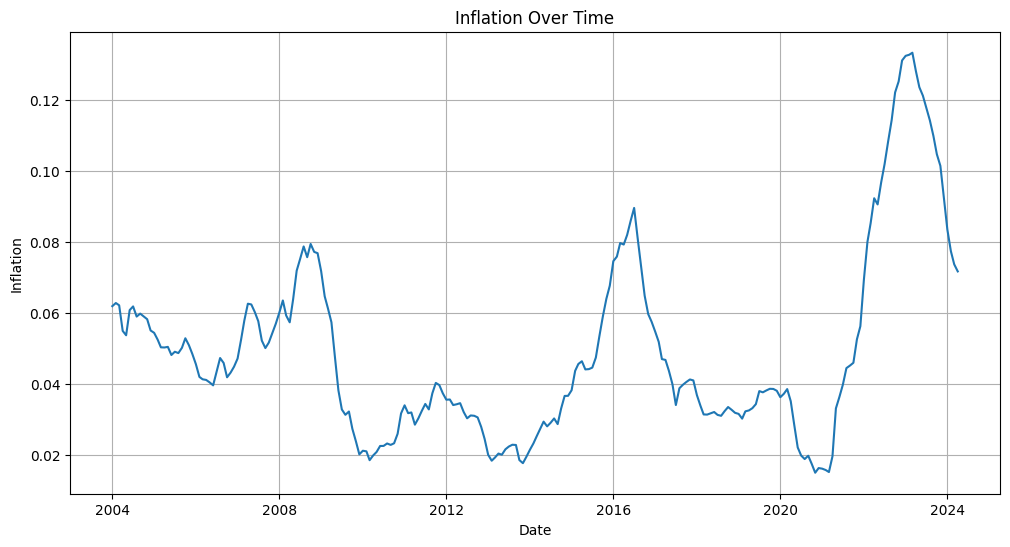

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Inflation'])
plt.title('Inflation Over Time')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.grid(True)
plt.show()

Regarding the treatment of the data, Inflation serie is scaled as follows.

In [ ]:
# Data Preprocessing
scaler = StandardScaler()
scaled_data = data
scaled_data['Inflation'] = scaler.fit_transform(scaled_data[['Inflation']].values)
scaled_data.head()

,ANIO,MES,IPC,Inflation,TRM_promedio,TRM_cierre,ISE,PRECIP_GAP
FECHA,,,,,,,,
2004-01-01,2004,1,53.54,0.482086,2749.14,2742.47,NaN,-224.332411
2004-02-01,2004,2,54.18,0.515703,2717.94,2682.34,NaN,-251.224087
2004-03-01,2004,3,54.71,0.491294,2670.80,2678.16,NaN,-387.392292
2004-04-01,2004,4,54.96,0.218071,2639.60,2646.99,NaN,230.907115
2004-05-01,2004,5,55.17,0.171680,2719.43,2724.92,NaN,207.587352


## **Method**

We will implement an Long Short Term Memory (LSTM) Neural Network. The autors describe the process as follows:

1.   Take the (training) sample January 2002 to December 2015 and a set of possible values for the hyperparameters. In our case, data starts in 2004.
2.   Train the model and compute the predictions twelve steps ahead. Calculate and store the RMSE per horizon.
3.  Add one month to the (training) sample, repeat the procedure until taking December 2018 in the sample (with forecasts until December 2019).
4.  Average the RMSE between samples for each forecast horizon. Calculate and store the associated RWMSE.
5.  Repeat the procedure changing the values of the hyperparameters until complete the grid defined with Bayessian Optimization.
6.  Choose the model with the hyperparameter values that generated the lowest RWMSE.





In [ ]:
# Function to create Inflation Rate Sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 12

In [ ]:
# Configuración de la optimización bayesiana
def lstm_evaluate(n_neurons, dropout_rate, epochs, batch_size):
  # Asegurarse de que estos valores sean enteros
  n_neurons = int(n_neurons)
  epochs = int(epochs)
  batch_size = int(batch_size)

  rmse_scores = []

  for end_date in pd.date_range('2015-12-01', '2018-12-01', freq='MS'):
      train_data = scaled_data['Inflation'][:end_date]

      trainX, trainY = create_sequences(train_data.values.reshape(-1,1), seq_length)
      trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

      model = tf.keras.Sequential()
      model.add(tf.keras.layers.LSTM(50, input_shape=(trainX.shape[1], 1)))
      model.add(tf.keras.layers.Dense(1))
      model.compile(loss='mean_squared_error', optimizer='adam')

      # Entrenar el modelo
      model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

      # Realizar las predicciones
      predictions = []
      current_batch = train_data[-seq_length:]

      for _ in range(12):  # Predicción 12 meses hacia adelante
        pred_input = np.reshape(current_batch, (1, seq_length, 1))
        pred = model.predict(pred_input, verbose=0)[0]
        predictions.append(pred)
        current_batch = np.append(current_batch[1:], pred)

      #predictions = scaler.inverse_transform(predictions)
      true_values = data['Inflation'][end_date + pd.DateOffset(months=1):end_date + pd.DateOffset(months=12)]
      rmse = np.sqrt(mean_squared_error(true_values, predictions))
      rmse_scores.append(rmse)

  return -np.mean(rmse_scores)

In [ ]:
# Rango de los hiperparámetros
pbounds = {
    'n_neurons': (4, 128),
    'dropout_rate': (0.2, 0.4),
    'epochs': (20, 200),
    'batch_size': (16, 128)
}

optimizer = BayesianOptimization(
    f=lstm_evaluate,
    pbounds=pbounds,
    verbose=2,
    random_state=42
)

optimizer.maximize(init_points=2, n_iter=1)

# Resultados de la optimización
print(optimizer.max)

|   iter    |  target   | batch_... | dropou... |  epochs   | n_neurons |
-------------------------------------------------------------------------


In [19]:
best_params

{'batch_size': 57.948493310904595,
 'dropout_rate': 0.3901428612819833,
 'epochs': 151.75890952605292,
 'n_neurons': 78.23365204043253}

In [106]:
best_params= optimizer.max['params']


train_data = scaled_data['Inflation'][:'2018-12-01']
X, y = create_sequences(train_data.values.reshape(-1,1), seq_length)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=int(best_params['n_neurons']), return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(best_params['dropout_rate']))
model.add(LSTM(units=int(best_params['n_neurons'])))
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X, y, epochs=int(best_params['epochs']), batch_size=int(best_params['batch_size']), verbose=1)

Epoch 1/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.4222
Epoch 2/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2862
Epoch 3/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2163
Epoch 4/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2306
Epoch 5/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1775
Epoch 6/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1653
Epoch 7/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1658
Epoch 8/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1616
Epoch 9/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1357
Epoch 10/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1173
Epoch 11/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1234
Epoch 12/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0906
Epoch 13/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0895
Epoch 14/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0811
Epoch 15/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0696
Epoch 16/151
3/3 ━━

In [96]:
test_data = scaled_data['Inflation']
X_test, y_test = create_sequences(test_data.values.reshape(-1,1), seq_length)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_values = []
actual_values = []

for i in range(y_test.shape[0]):
    prediction = model.predict(X_test[i])
    prediction = scaler.inverse_transform(prediction)
    predicted_values.append(prediction[0][0])
    actual_values.append(scaler.inverse_transform(y_test[i].reshape(-1,1))[0][0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

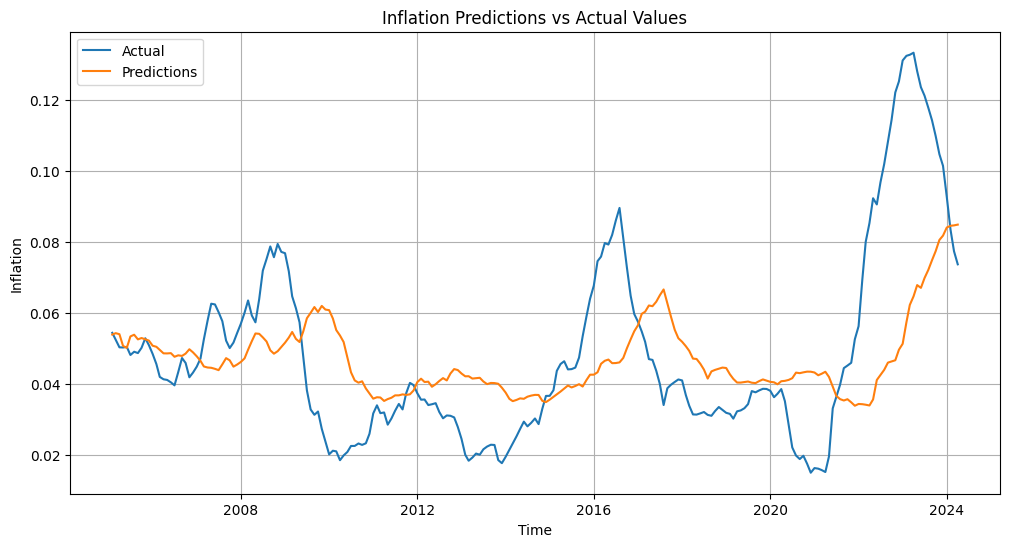

In [97]:
fechas = data['2005-02-01':].index
plt.figure(figsize=(12, 6))
plt.plot(fechas,actual_values, label='Actual')
plt.plot(fechas,predicted_values, label='Predictions')
plt.title('Inflation Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Inflation')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


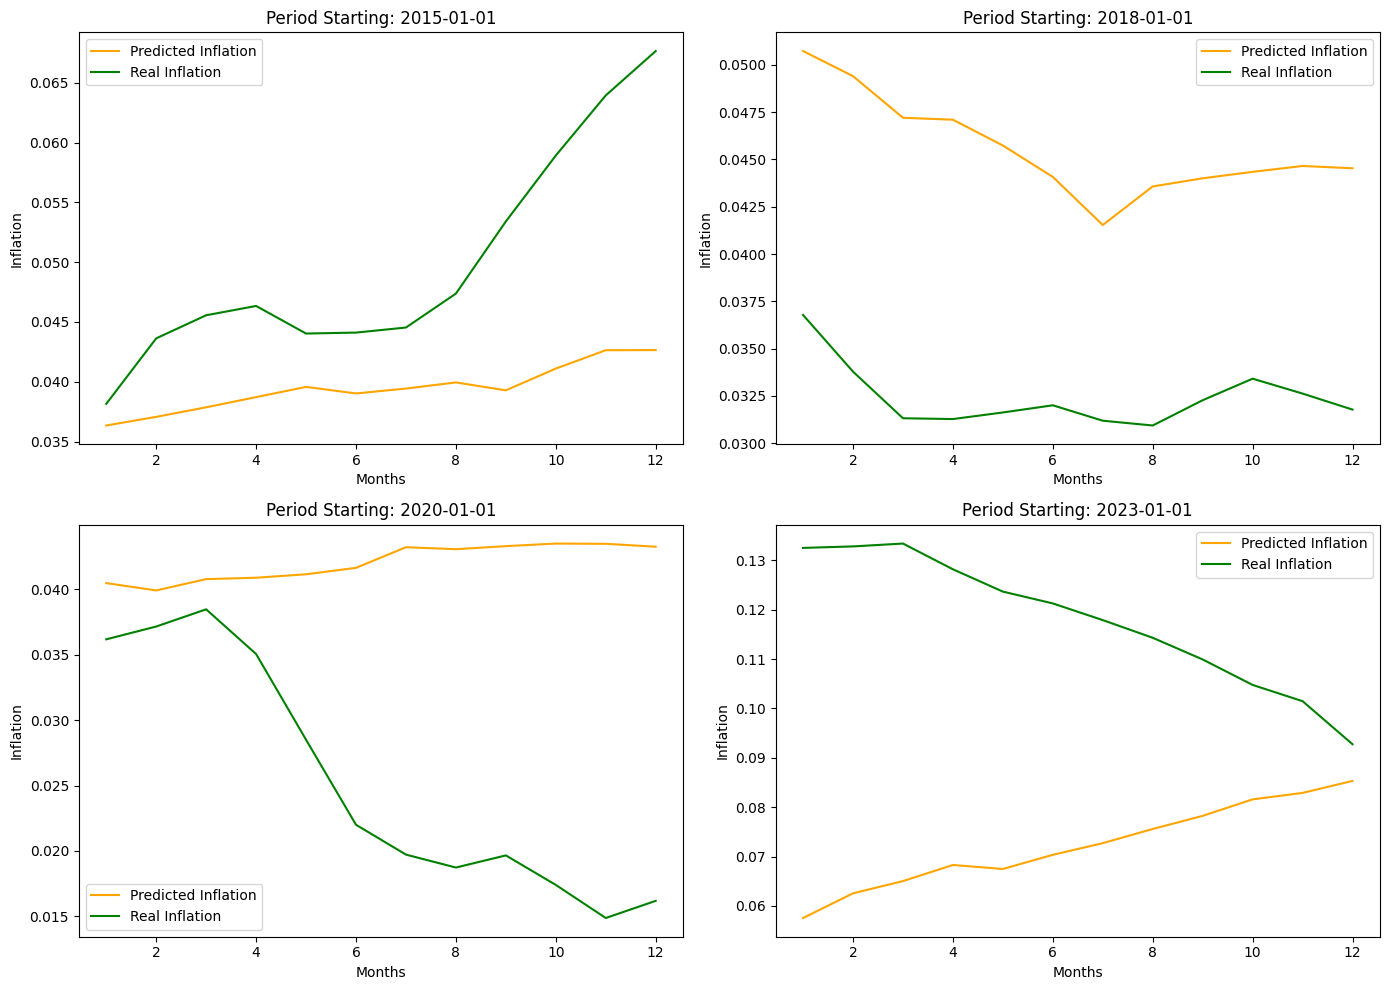

In [107]:
periods = ['2015-01-01', '2018-01-01', '2020-01-01', '2023-01-01']

# Listas para guardar predicciones y valores reales
predicted_values_periods = []
actual_values_periods = []

for period in periods:
  start_idx = scaled_data.index.get_loc(period)
  X_test = scaled_data['Inflation'][start_idx - seq_length:start_idx].values.reshape(-1, 1)
  prediction = model.predict(X_test)  # Predice con la secuencia actual
  prediction = scaler.inverse_transform(prediction)
  predicted_values_periods.append(prediction)
  actual_values = test_data.values[start_idx:start_idx + 12].reshape(-1, 1)
  actual_values = scaler.inverse_transform(actual_values)
  actual_values_periods.append(actual_values)

# Graficar los resultados


plt.figure(figsize=(14, 10))

for i, period in enumerate(periods):
    plt.subplot(2, 2, i + 1)
    plt.plot(np.arange(1, 13), predicted_values_periods[i], color='orange', label='Predicted Inflation')
    plt.plot(np.arange(1, 13), actual_values_periods[i], color='green', label='Real Inflation')
    plt.title(f'Period Starting: {period}')
    plt.xlabel('Months')
    plt.ylabel('Inflation')
    plt.legend()

plt.tight_layout()
plt.show()

In [111]:
best_params_test= {'batch_size': 57.948493310904595,
                   'dropout_rate': 0,
                   'epochs': 151.75890952605292,
                   'n_neurons': 78.23365204043253}

train_data = scaled_data['Inflation'][:'2018-12-01']
X, y = create_sequences(train_data.values.reshape(-1,1), seq_length)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=int(best_params_test['n_neurons']), return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(best_params_test['dropout_rate']))
model.add(LSTM(units=int(best_params_test['n_neurons'])))
model.add(Dropout(best_params_test['dropout_rate']))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X, y, epochs=int(best_params_test['epochs']), batch_size=int(best_params_test['batch_size']), verbose=1)

Epoch 1/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.4314
Epoch 2/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2666
Epoch 3/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2197
Epoch 4/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2158
Epoch 5/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1660
Epoch 6/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1656
Epoch 7/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1652
Epoch 8/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1659
Epoch 9/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1315
Epoch 10/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1233
Epoch 11/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0999
Epoch 12/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0866
Epoch 13/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0722
Epoch 14/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0662
Epoch 15/151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0546
Epoch 16/151
3/3 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

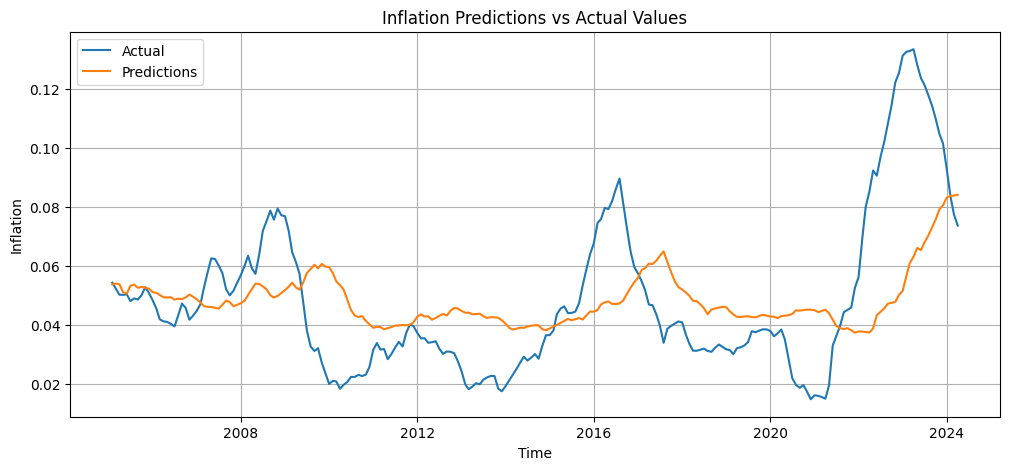

In [112]:
test_data = scaled_data['Inflation']
X_test, y_test = create_sequences(test_data.values.reshape(-1,1), seq_length)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_values = []
actual_values = []

for i in range(y_test.shape[0]):
    prediction = model.predict(X_test[i])  # Predice con la secuencia actual
    prediction = scaler.inverse_transform(prediction)  # Invierte el escalamiento
    predicted_values.append(prediction[0][0])  # Guarda la predicción
    actual_values.append(scaler.inverse_transform(y_test[i].reshape(-1,1))[0][0])



fechas = data['2005-02-01':].index
plt.figure(figsize=(12, 5))
plt.plot(fechas,actual_values, label='Actual')
plt.plot(fechas,predicted_values, label='Predictions')
plt.title('Inflation Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Inflation')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


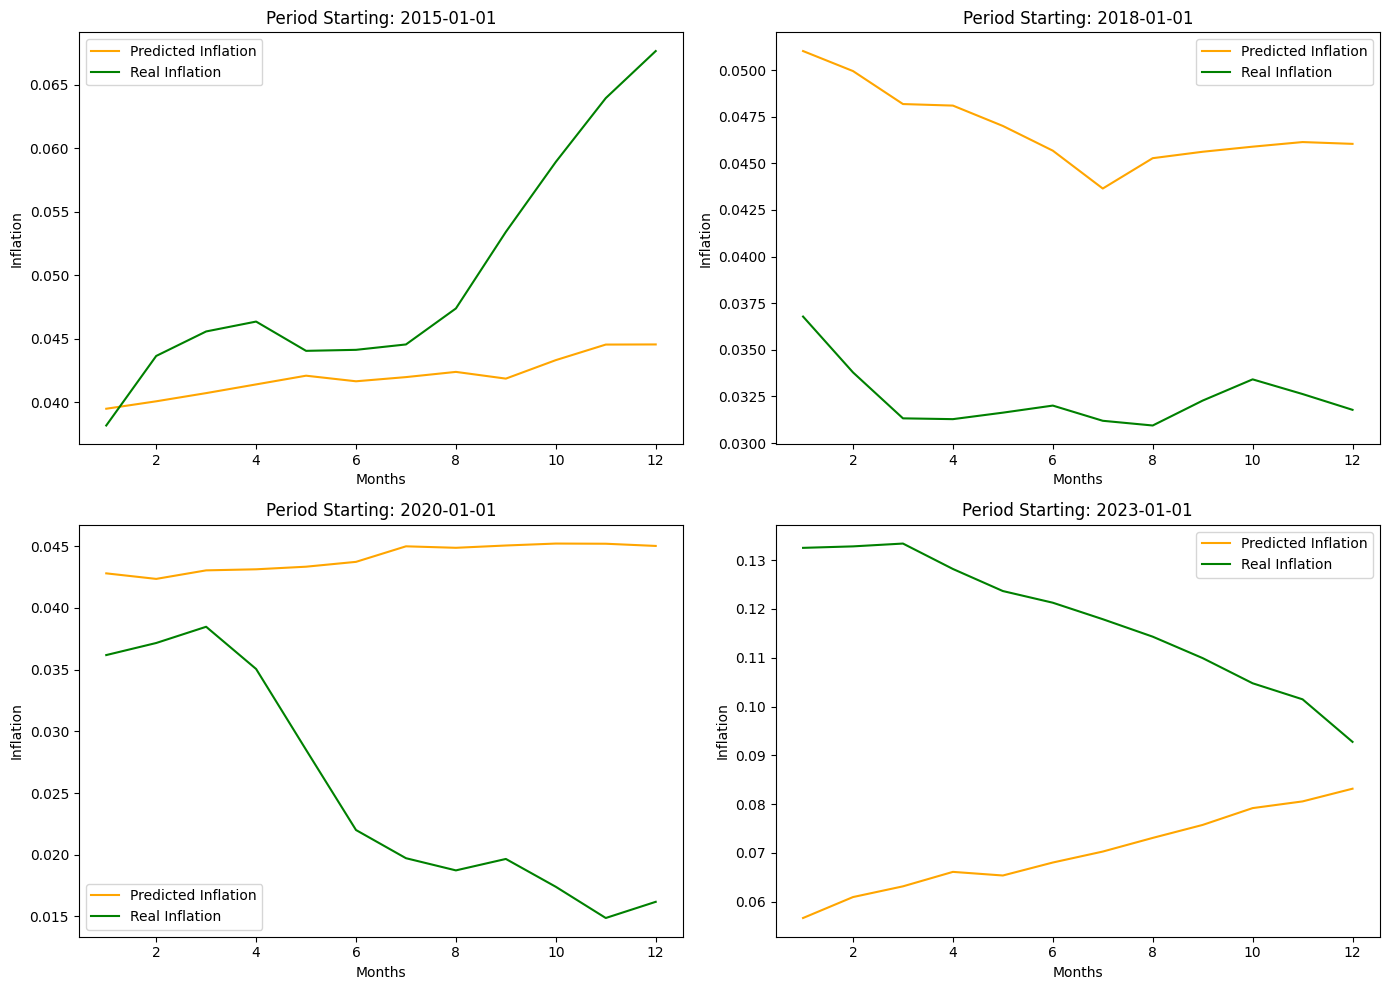

In [113]:
predicted_values_periods = []
actual_values_periods = []

for period in periods:
  start_idx = scaled_data.index.get_loc(period)
  X_test = scaled_data['Inflation'][start_idx - seq_length:start_idx].values.reshape(-1, 1)
  prediction = model.predict(X_test)  # Predice con la secuencia actual
  prediction = scaler.inverse_transform(prediction)
  predicted_values_periods.append(prediction)
  actual_values = test_data.values[start_idx:start_idx + 12].reshape(-1, 1)
  actual_values = scaler.inverse_transform(actual_values)
  actual_values_periods.append(actual_values)

# Graficar los resultados


plt.figure(figsize=(14, 10))

for i, period in enumerate(periods):
    plt.subplot(2, 2, i + 1)
    plt.plot(np.arange(1, 13), predicted_values_periods[i], color='orange', label='Predicted Inflation')
    plt.plot(np.arange(1, 13), actual_values_periods[i], color='green', label='Real Inflation')
    plt.title(f'Period Starting: {period}')
    plt.xlabel('Months')
    plt.ylabel('Inflation')
    plt.legend()

plt.tight_layout()
plt.show()

In [109]:
best_params_test= {'batch_size': 60.35,
                   'dropout_rate': 0.2,
                   'epochs': 94.33,
                   'n_neurons':  15.69}

train_data = scaled_data['Inflation'][:'2018-12-01']
X, y = create_sequences(train_data.values.reshape(-1,1), seq_length)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=int(best_params_test['n_neurons']), return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(best_params_test['dropout_rate']))
model.add(LSTM(units=int(best_params_test['n_neurons'])))
model.add(Dropout(best_params_test['dropout_rate']))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X, y, epochs=int(best_params_test['epochs']), batch_size=int(best_params_test['batch_size']), verbose=1)

Epoch 1/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.5286
Epoch 2/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4808
Epoch 3/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4263 
Epoch 4/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4113 
Epoch 5/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3475 
Epoch 6/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3320 
Epoch 7/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3005 
Epoch 8/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2816
Epoch 9/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2588
Epoch 10/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2602
Epoch 11/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2384 
Epoch 12/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2265 
Epoch 13/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2220 
Epoch 14/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2144
Epoch 15/94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2090
Epoch 16/94
3/3 ━━━━━━━━━━